## What salary could get a candidate after transition?

In this section was trained an XGBoost regression model to estimate salaries for Data Scientist roles, focusing on the skill sets identified as critical for transitioning from a Data Analyst role. The analysis includes:

- Engineering binary features for the transition skills defined earlier
- Training an XGBoost regression model
- Predicting monthly salaries for Data Scientist candidates

### Import Libraries

In [10]:
from pathlib import Path
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

import matplotlib.pyplot as plt

### Load Cleaned Dataset

In [11]:
df = pd.read_pickle(Path.cwd().parents[1] / 'Raw_Data' / 'df_Final_2.pkl')

Filter the dataset by the **Target Role: Data Scientist**

In [12]:
df_ml = df[df['job_title_short'] == 'Data Scientist'].copy()

print(f"Valid Data Scientist rows: {len(df_ml)}")

Valid Data Scientist rows: 9507


### Feature Engineering

To evaluate how specific skills and job attributes influence salaries, it was engineered binary features (1 if present, 0 if absent) based on job postings. This allows us to model the presence of key skills and requirements systematically.

**Base skills:**
- `Python`
- `SQL`
- `Tableau` or equal visualisation tool as `Power BI` or `Looker`.

Tableau, Power BI and Looker are grouped into 'Visualisation tools' so it meet criteria if the candidate knows at least 1 of these tools.

**Transition skills:**
- `R` or `SAS` - as specialized in statistics and legacy systems.
- `AWS` or `Azure` - cloud platforms increasingly required for scalable data solutions.
- `Spark`, `TensorFlow`, or `PyTorch` - big data and machine learning frameworks.

Criteria is met if the candidate knows at least 1 tool in each group.

In [13]:
# Lowercase skill lists
df_ml['job_skills'] = df_ml['job_skills'].apply(lambda x: [s.lower() for s in x] if isinstance(x, list) else [])

# Define skill groups
viz_tools = ['tableau', 'power bi', 'looker']
r_sas = ['r', 'sas']
spark_tf_pt = ['spark', 'tensorflow', 'pytorch']
aws_azure = ['aws', 'azure']

# Individual known skills
df_ml['has_python'] = df_ml['job_skills'].apply(lambda skills: 'python' in skills).astype(int)
df_ml['has_sql'] = df_ml['job_skills'].apply(lambda skills: 'sql' in skills).astype(int)

# Group features
df_ml['has_viz_tool'] = df_ml['job_skills'].apply(lambda skills: any(v in skills for v in viz_tools)).astype(int)
df_ml['has_r_sas'] = df_ml['job_skills'].apply(lambda skills: any(v in skills for v in r_sas)).astype(int)
df_ml['has_spark_tf_pt'] = df_ml['job_skills'].apply(lambda skills: any(v in skills for v in spark_tf_pt)).astype(int)
df_ml['has_aws_azure'] = df_ml['job_skills'].apply(lambda skills: any(v in skills for v in aws_azure)).astype(int)

# List of skill features
skill_cols = ['has_python','has_sql','has_viz_tool',
              'has_r_sas','has_spark_tf_pt','has_aws_azure','total_skills','meets_criteria']

# Total skills count in posting
df_ml['total_skills'] = df_ml['job_skills'].apply(len)

# Composite feature: candidate meets all conditions
df_ml['meets_criteria'] = (
    df_ml['has_python'] &
    df_ml['has_sql'] &
    df_ml['has_viz_tool'] &
    df_ml['has_r_sas'] &
    df_ml['has_spark_tf_pt'] &
    df_ml['has_aws_azure']
).astype(int)

df_ml[skill_cols].sum()

has_python          7763
has_sql             5727
has_viz_tool        2508
has_r_sas           4597
has_spark_tf_pt     2783
has_aws_azure       2313
total_skills       54603
meets_criteria       119
dtype: int64

### Encode categorical variables

In addition to skills, job attributes like schedule type and location can influence salary and candidate fit. It was created binary (0/1) features for these attributes to make them suitable for modeling:

- Schedule type – postings can list multiple types (Full-time, Part-time, Contractor, Temp work, Internship). Each as a separate column was encoded using a multi-hot representation: 1 if the posting includes that schedule type, 0 otherwise.
- Location indicators – for example, is_eu identifies if the job is based in the European Union. 
- Other categorical/binary attributes – such as job_work_from_home and job_health_insurance.

These transformations allow to systematically include categorical and binary job characteristics in the analysis, enabling models to capture how schedule, location, and benefits relate to salaries.

In [14]:
# Multi-hot schedule type
schedule_types = ["Full-time", "Part-time", "Contractor", "Temp work", "Internship"]

for s in schedule_types:
    col = "schedule_" + s.lower().replace(" ", "_").replace("-", "_")
    # Assign 1 if schedule string contains this type, else 0
    df_ml[col] = df_ml['job_schedule_type'].fillna("").apply(lambda x: int(s in x))

# Additional categorical/binary features
df_ml['is_us'] = (df_ml['job_country'] == "United States").astype(int)

# Collect categorical/binary columns (no schedule_missing here)
categorical_cols = ['is_eu', 'is_us', 'job_work_from_home', 'job_health_insurance']
categorical_cols += [c for c in df_ml.columns if c.startswith("schedule_")]

print("Categorical/binary features counts:\n")
print(df_ml[categorical_cols].sum())

Categorical/binary features counts:

is_eu                    328
is_us                   7480
job_work_from_home      1809
job_health_insurance    4925
schedule_full_time      9247
schedule_part_time       555
schedule_contractor      265
schedule_temp_work        95
schedule_internship       65
dtype: int64


### Merge all features into modeling dataset

In [15]:
# All model features
model_features = skill_cols + categorical_cols

# Target
y = df_ml['salary_month_avg_eur']
X = df_ml[model_features]

# Summary of df_model
print(f"\ndf_model created with {df_ml.shape[0]} rows and {df_ml.shape[1]} features.")
print("Target variable: salary_month_avg_eur")


df_model created with 9507 rows and 33 features.
Target variable: salary_month_avg_eur


### Train XGBoost model

XGBoost can handle both numerical features (like years of experience) and categorical features (like job type, e.g., 'full time' or 'temporary'). This is crucial for salary prediction, as we're dealing with a mix of both. It automatically handles the conversion of categorical variables into a numerical format, often through one-hot encoding or similar techniques.

While powerful, XGBoost includes built-in regularization techniques (like max_depth and learning_rate) that help prevent the model from becoming too complex and overfitting the training data. This ensures it generalizes well to new, unseen candidates.

In [16]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train
model = XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

print("Training R^2:", round(model.score(X_train, y_train), 4))
print("Test R^2:", round(model.score(X_test, y_test), 4))

Training R^2: 0.3416
Test R^2: 0.1511


R^2 of 0.1511 on the test set could be considered sufficient for the model because salary prediction is a very complex problem with many unmeasurable factors, making a high score difficult to achieve. Given the dataset's high dimensionality, further tuning might not significantly improve the score, as the model may have already extracted most of the predictable information from the data.

### Candidate prediction

In [17]:
# Candidate feature vector
candidate_features = pd.DataFrame([{
    'has_python': 1,
    'has_sql': 1,
    'has_viz_tool': 1,
    'has_r_sas': 1,
    'has_spark_tf_pt': 1,
    'has_aws_azure': 1,
    'total_skills': 6,
    'meets_criteria': 0,
    
    'is_eu': 1,
    'is_us': 0,
    'job_work_from_home': 0,
    'job_health_insurance': 0,
    
    'schedule_full_time': 1,
    'schedule_part_time': 0,
    'schedule_contractor': 0,
    'schedule_temp_work': 1,
    'schedule_internship': 0
    
}])

# Predict salary
predicted_salary = model.predict(candidate_features)[0]
print(f"Predicted salary for candidate: {predicted_salary:.2f} EUR/month")

Predicted salary for candidate: 10555.47 EUR/month


### Salary that can get the candidate after transition

Let's compare salary that the candidate can get after transition with median salaries of Data Analysts and Data Scientists depending on number of skills.

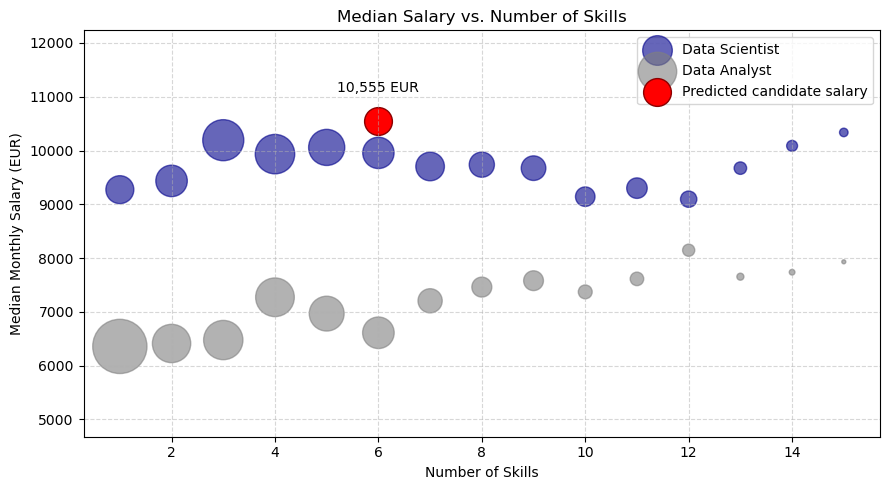

In [44]:
# Ensure total_skills exists for all postings
df['job_skills'] = df['job_skills'].apply(lambda x: [s.lower() for s in x] if isinstance(x, list) else [])
df['total_skills'] = df['job_skills'].apply(len)

# Filter <= 15 skills
df_ds_filtered = df[(df['job_title_short'] == 'Data Scientist') & (df['total_skills'] <= 15)]
df_da_filtered = df[(df['job_title_short'] == 'Data Analyst') & (df['total_skills'] <= 15)]

# Compute median salaries and counts per skill count
median_ds = df_ds_filtered.groupby('total_skills').agg(
    median_salary=('salary_month_avg_eur', 'median'),
    count=('salary_month_avg_eur', 'size')
).reset_index()
median_da = df_da_filtered.groupby('total_skills').agg(
    median_salary=('salary_month_avg_eur', 'median'),
    count=('salary_month_avg_eur', 'size')
).reset_index()

# Plotting
plt.figure(figsize=(9,5))

# Data Scientist points
plt.scatter(
    median_ds['total_skills'],
    median_ds['median_salary'],
    s=median_ds['count']*0.6,  
    c='darkblue',
    alpha=0.6,
    label='Data Scientist'
)

# Data Analyst points
plt.scatter(
    median_da['total_skills'],
    median_da['median_salary'],
    s=median_da['count']*0.6,
    c='gray',
    alpha=0.6,
    label='Data Analyst'
)

# Predicted candidate salary
plt.scatter(
    candidate_features['total_skills'].iloc[0],
    predicted_salary,
    s=400,  
    c='red',
    edgecolor='darkred',
    label='Predicted candidate salary',
    zorder=1
)
plt.text(
    candidate_features['total_skills'].iloc[0],
    predicted_salary + predicted_salary * 0.07,
    f"{predicted_salary:,.0f} EUR",
    ha='center',
    va='top',
    fontsize=10
)

# Axis labels and title
plt.xlabel('Number of Skills')
plt.ylabel('Median Monthly Salary (EUR)')
plt.title('Median Salary vs. Number of Skills')
plt.grid(True, linestyle='--', alpha=0.5)
plt.margins(y=0.4)
plt.legend()
plt.tight_layout()

plt.show()

The blue and gray circles show how the median salary generally increases with the number of skills for both **Data Scientists** and **Data Analysts**, with larger circles representing more job postings. 

By overlaying the candidate's **predicted salary** as a red point, the plot provides crucial context - predicted salary for the Data Scientist role with certain skills we defined before is **above the market typically offers**.

### Conclusion:
Learning only 3 certain additional skills to a **Data Analyst** skillset the candidate can successfully transfer to **Data Scientist** role with even higher than median salary.